### Novartis Data Challenge
Author: Eli Goldberg

Language: Python 3.5+
    
#### Disclaimer
2-4 hours seemed quite short for what I wanted to do, without recycling functions from elsewhere. However, I will say that everything employed here was coded within the given timeperiod. To keep things simple, I stuck to using the accelerometery data. There are other methods to employ this type of data, but given the time limit, it seemed reasonable to limit the analysis. 

### B) Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
mpl.rcParams['figure.figsize'] = (10,5)
import numpy as np
import math
import os

In [2]:
# define peakdetect from script - no time to mess with walking through setup.py
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array


def peakdet(v, delta, x=None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html

    Returns two arrays

    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.

    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.

    """
    maxtab = []
    mintab = []

    if x is None:
        x = arange(len(v))

    v = asarray(v)

    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')

    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')

    if delta <= 0:
        sys.exit('Input argument delta must be positive')

    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN

    lookformax = True

    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]

        if lookformax:
            if this < mx - delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn + delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

### C) Read in data
* I used pandas to read the shimmer file .csv into a dataframe, knowing that the delimiter is ';'. 

* The headers were long and overly descriptive, so I changed them to something simpler. In addition, the units are contained in the second row of the file, so I filtered that out in a rather inelegant, but effective, fashion. 

In [3]:
# read in data
data = pd.read_csv('shimmer.csv', delimiter=';',low_memory=False)

# define array of simplified headers
new_headers = ['t_ms', 'ax_cal', 'ay_cal', 'az_cal',
               'ax_acl_wr', 'ay_acl_wr', 'az_acl_wr',
               'gx_cal', 'gy_cal', 'gz_cal', 'mx_cal',
               'my_cal', 'mz_cal']

# replace the headers
data = pd.DataFrame(data.as_matrix(), columns=new_headers)

# remove the units row
data = data[1:]

# print the first 5 rows to check
print(data.head())

          t_ms        ax_cal        ay_cal        az_cal     ax_acl_wr  \
1  979.2480469  -0.204819277  -9.253012048  -0.554216867  -0.592592593   
2  989.0136719  -0.168674699  -9.542168675  -0.927710843  -0.592592593   
3  998.7792969  -0.072289157  -9.771084337  -1.481927711  -0.711111111   
4  1008.544922  -0.072289157  -9.915662651  -1.421686747  -0.355555556   
5  1018.310547  -0.120481928  -9.903614458  -1.253012048   -0.82962963   

      ay_acl_wr     az_acl_wr       gx_cal       gy_cal       gz_cal  \
1  -9.362962963  -0.948148148  6.183206107  0.229007634  3.938931298   
2  -9.362962963  -0.711111111   3.58778626  1.221374046  1.267175573   
3  -9.244444444  -1.066666667  5.160305344  1.083969466  1.435114504   
4  -9.481481481  -1.066666667  14.32061069  1.740458015  0.916030534   
5  -9.718518519   -0.82962963  25.49618321  2.183206107  0.351145038   

         mx_cal       my_cal       mz_cal  
1   -0.49005848  0.223391813  0.046052632  
2   -0.49005848  0.223391813  0.04

### D) Combining features to create more interpretable data
Working with raw acceleration and magnetometry data can be useful, but it's often helpful to combine these data to make more interpretable features, like the total acceleration magnitude, and pitch and roll (if you don't care about direction, which we don't for a balance exercise).

It can be slow to manually apply data to large matrices, so I've created some simple functions to be used with pandas' apply functionality for their dataframes. 
* acc2totalMag: total acceleration magnitude should help us determine shaking from not shaking


In [4]:
def acc2totalMag(row):
    Ax = float(row['ax_cal'])
    Ay = float(row['ay_cal'])
    Az = float(row['az_cal'])
    return math.sqrt(Ax ** 2 + Ay ** 2 + Az ** 2)

def acc2pitch(row):
    ''' https://stanford.edu/class/ee267/lectures/lecture10.pdf
    assumes y-axis is up'''
    Ax = float(row['ax_cal'])
    Ay = float(row['ay_cal'])
    Az = float(row['az_cal'])
    return math.degrees(-math.atan2(Az, math.sqrt(Ax ** 2 + Ay ** 2)))

def acc2roll(row):
    ''' https://stanford.edu/class/ee267/lectures/lecture10.pdf
    assumes y-axis is up'''
    Ax = float(row['ax_cal'])
    Ay = float(row['ay_cal'])
    Az = float(row['az_cal'])
    return math.degrees(-math.atan2(-Ax, Ay))

In [5]:
# apply the functions to the data. 
data['totalMag'] = data.apply(acc2totalMag, axis=1)
data['pitch'] = data.apply(acc2pitch, axis=1)
data['roll'] = data.apply(acc2roll, axis=1)

### E) Determining start/stop events for balance test 
My first inclination to determine the start/stop times for the balance test is to look at the magnitude of total acceleration. As given in the prompt, at the start and end of each balance test, the subject was asked to shake the sensor vigorously. Also, each balance test lasted for a duration of 40 seconds! A completely autonomous signal analysis isn't super trivial to do, but i'll give it my best in the remaining time. 

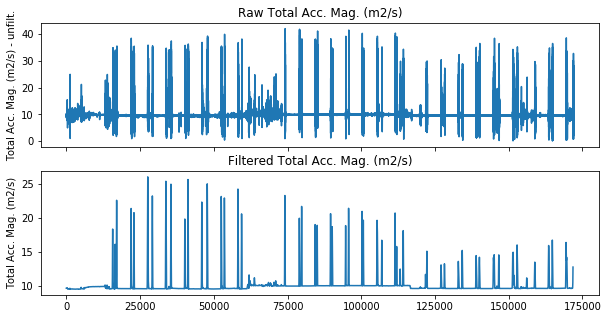

In [65]:
# the signal is noisy, so introduce a quick weighted moving ave filter
def weighted_moving_average(signal=[], weights=[]):
    ''' use a quick convolution to smooth the signal'''
    w_signal = np.convolve(signal, np.array(weights)[::-1], mode='valid')
    return w_signal / np.sum(weights)

time = data['t_ms']
sig_totMag = data['totalMag']
window_size = 200 
weights = np.hamming(window_size)
sig_totMag_weig_filt = weighted_moving_average(signal=sig_totMag, 
                                             weights=weights)

# Two subplots, plot the pitch and roll
f, axarr = plt.subplots(2, sharex=True)
axarr[0].set_title('Raw Total Acc. Mag. (m2/s)')
axarr[0].plot(sig_totMag)
axarr[0].set_ylabel('Total Acc. Mag. (m2/s) - unfilt.')
axarr[1].set_title('Filtered Total Acc. Mag. (m2/s)')
axarr[1].plot(sig_totMag_weig_filt)
axarr[1].set_ylabel('Total Acc. Mag. (m2/s)')
plt.show()

#### E.1) Unsupervised identification of start/stops
The above is likely ok for visual identification, but I think we can make a fairly simple unsupervised method. I'm starting to run low on time, so I'll try two easy classification schemes. The idea is to identify the start/stop periods, and use them to create seperate data files. This may result in an imperfect classification, but hey - I've only got limited time. 

* Classification by coefficient of variation (CV) for a moving window
* Classification by total signal energy deviation from mean for a moving window
* Peak identification with some post processing 
* Supervised ML-based classification with moving window (requires supervised data, which we could technically make)
* Clustering and PCA - we could project the singnals down to a few axes and see what pops up. This could also work well

There are a lot of things tht could be done, but it's a bit too much guess work and not enough time. I'll pick a method that's a bit more supervised, but effective given the time period - I hope. I'm likely wasting precious time writing commentary.

#### E.2) Peak detection with whole, and then subset, of the series
Well, I tried to do some peak detection of the entire series. It worked ok. Because the vigor of the shaking was not equal in each start/stop, you get some over-identification or under identification of peaks. It may be best to split the data up data into users at this point. This is only the first question though, so I'm not going to go crazy.

48 theoretical # of peaks
57 detected # of peaks


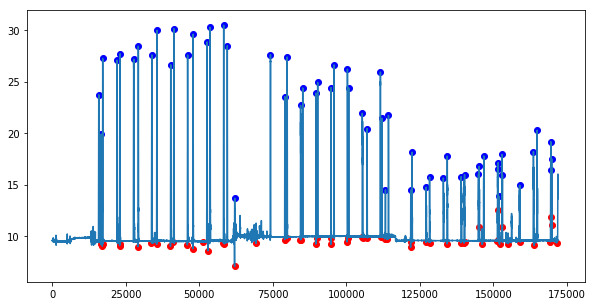

In [66]:
# theoretical total number of tests
subjects = 3
tests_per_subject = 8
on_offs_per_test = 2
total_on_ofs = subjects*tests_per_subject*on_offs_per_test
print(total_on_ofs, 'theoretical # of peaks')

# perhaps more signal shaping is needed - bring this into this cell
window_size = 50
weights = np.bartlett(window_size)
# weights = np.kaiser(window_size,5)
weights = np.ones(window_size)
sig_totMag_weig_filt = weighted_moving_average(signal=sig_totMag, 
                                             weights=weights)

#use the peakdet function introduced above
maxtab, mintab = peakdet(sig_totMag_weig_filt, 4)
print (len((maxtab)[:, 0]), 'detected # of peaks')
plt.plot(sig_totMag_weig_filt)
plt.scatter(array(maxtab)[:, 0], array(maxtab)[:, 1], color='blue')
plt.scatter(array(mintab)[:, 0], array(mintab)[:, 1], color='red')
plt.show()



#### E.3) Isolation of a single subject's data by start and stop time
Using the peak-assist data indices, I split the data into segments by visual inspection (i.e., counting the blue dots and figuring out which ones were in between data. I'd rather do it in a completely unsupervisd manner, but that's not possible with this short of time. Note: if you run this and then try to run it again, it'll break. To fix, re-run the previous cell. 

In [67]:
# Manual ID using peak-assisted indexes. 
# subject 1: peak ids for start/stop = 1, 18
subj_1_index_start = int(array(maxtab)[1, 0])
subj_1_index_stop = int(array(maxtab)[18, 0])
print(subj_1_index_start,subj_1_index_stop)

# subject 2
# peak ids for start/stop = 19, 35
subj_2_index_start = int(array(maxtab)[18, 0])
subj_2_index_stop = int(array(maxtab)[35, 0])
print(subj_2_index_start,subj_2_index_stop)

# subject 2
# peak ids for start/stop = 36, 56
subj_3_index_start = int(array(maxtab)[36, 0])
subj_3_index_stop = int(array(maxtab)[56, 0])
print(subj_3_index_start,subj_3_index_stop)

16630 74172
74172 121871
122316 169792


#### E.4) Plotting and delineating start/stops for subject 1. 
Isolating a single subjects data allows us to make the peak detection function introduced above a bit more sensitive. It turns out that it wasn't needed for subject one. However, it's suggested that the first and last 5 seconds for each data should be discarded (5 seconds = 5s*102.4/s = 512 data points on each end). 

17 detected # of peaks


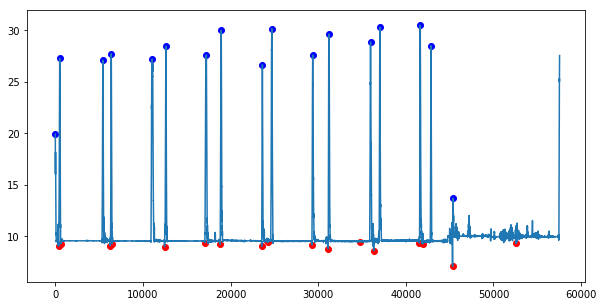

[  1013.   6900.  13128.  19447.  25214.  31757.  37538.  43381.]
[  4912.  10544.  16721.  23117.  28859.  35459.  41119.  44869.]


In [68]:
# for subject 1
#use the peakdet function introduced above
maxtab, mintab = peakdet(sig_totMag_weig_filt[subj_1_index_start:subj_1_index_stop], 3)
print (len((maxtab)[:, 0]), 'detected # of peaks')
plt.plot(sig_totMag_weig_filt[subj_1_index_start:subj_1_index_stop])
plt.scatter(array(maxtab)[:, 0], array(maxtab)[:, 1], color='blue')
plt.scatter(array(mintab)[:, 0], array(mintab)[:, 1], color='red')
plt.show()

# remove a bit of the front and back, because the first/last part of each run is garbage. 
# then grab the indexes for the data in between the peaks
# start data 
sub1_start = (maxtab)[:, 0][1::2] + 512
sub1_stop = (maxtab)[:, 0][2::2] - 512
print(sub1_start)
print(sub1_stop)



#### E.5) Plotting and delineating start/stops for subject 2. 
I increased the peak thresholding to remove the errors detected in subject two in test 8. Without better notes, it's not clear to me if test 8 ended at the last peak, or if that was the reset. As such, I'm tempted to keep my pure list comprehesion method for extraction. 

16 detected # of peaks


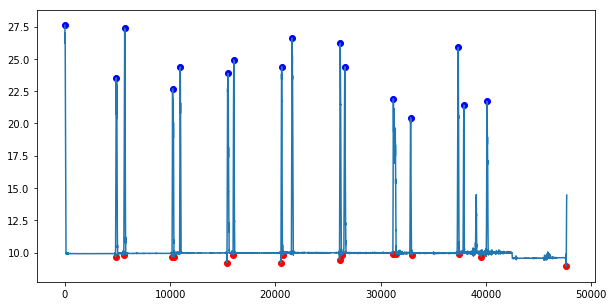

[   512.   6194.  11478.  16566.  22112.  27115.  33372.  38426.]
[  4365.   9725.  14974.  20090.  25658.  30709.  36878.  39607.]


In [69]:
# for subject 2
#use the peakdet function introduced above
maxtab, mintab = peakdet(sig_totMag_weig_filt[subj_2_index_start:subj_2_index_stop], 5)
print (len((maxtab)[:, 0]), 'detected # of peaks')
plt.plot(sig_totMag_weig_filt[subj_2_index_start:subj_2_index_stop])
plt.scatter(array(maxtab)[:, 0], array(maxtab)[:, 1], color='blue')
plt.scatter(array(mintab)[:, 0], array(mintab)[:, 1], color='red')
plt.show()

# remove a bit of the front and back, because the first/last part of each run is garbage. 
# then grab the indexes for the data in between the peaks
# start data starts at 0 index for maxtab starts,and 1 for maxtab stops
sub2_start = (maxtab)[:, 0][::2] + 512
sub2_stop = (maxtab)[:, 0][1::2] - 512
print(sub2_start)
print(sub2_stop)


#### E.6) Plotting and delineating start/stops for subject 3. 
Please note that typically, I would do this with a clever loop. However, this game seems to be about speed. Also, I do see some problems in using pure list comprehension to specify the starts/stops for subject 3, as the early failure in the 6th test caused a restart. I'll threshold as much as possible needed and then create the indexes specifically, if needed. Turns out a threshold of 5.3 for the peakdet worked well, but test 7 only has one start point. Therefore I created seperate vectors with the peak number (0-14), so I could relate that back to the index. Could be more efficient. You can see the fail on test 6 clearly.

15 detected # of peaks


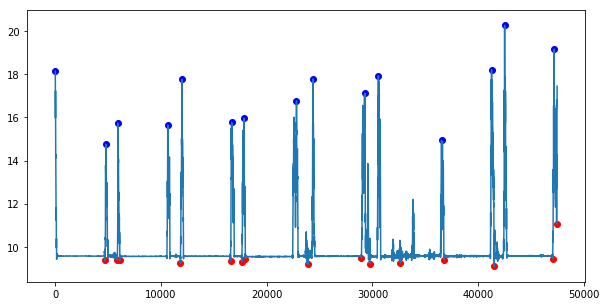

[512.0, 6460.0, 12487.0, 18354.0, 24890.0, 31077.0, 37049.0, 43020.0]
[4272.0, 10128.0, 16173.0, 22307.0, 28772.0, 36025.0, 40761.0, 46664.0]


In [70]:
# for subject 3
#use the peakdet function introduced above
maxtab, mintab = peakdet(sig_totMag_weig_filt[subj_3_index_start:subj_3_index_stop], 5.3)
print (len((maxtab)[:, 0]), 'detected # of peaks')
plt.plot(sig_totMag_weig_filt[subj_3_index_start:subj_3_index_stop])
plt.scatter(array(maxtab)[:, 0], array(maxtab)[:, 1], color='blue')
plt.scatter(array(mintab)[:, 0], array(mintab)[:, 1], color='red')
plt.show()

# create vectors of start/stop indices into new arrays
select_start_index = [0,2,4,6,8,10,11,13]
select_stop_index = [1,3,5,7,9,11,12,14]

# initialize bins for indices
sub3_start = []
sub3_stop = []

# loop through selected peaks and pull out indices for each
for i in range(0,len(select_start_index)):
    sub3_start.append((maxtab)[select_start_index[i], 0] + 512)
    sub3_stop.append((maxtab)[select_stop_index[i], 0] - 512)

print(sub3_start)
print(sub3_stop)

#### F) visualizing the pitch and roll for the entire time series
Now that we've got a semi-autonomous method to isolate each subject's signal by inspection of the total magnitude of acceleration, let's take a look at it. 

As indicated in the prompt, the sensors were occasionally oriented such that the typical 'up' direction, the y-axis, was perpendicular to gravity. However, looking at the roll, it's likely that the sensors were perpendicular to gravity during this period. I also scaled the x-axis to reflect time and not device cycles. 

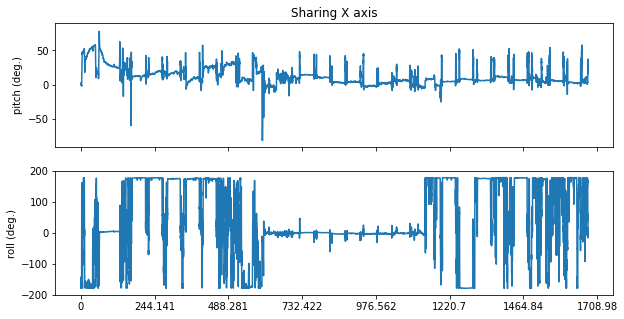

In [71]:

# weighted moving characteristics
window_size = 50
weights = np.hamming(window_size)
weights = np.ones(window_size) # equal to a moving average

sig_roll = data['roll']
sig_pitch = data['pitch']
sig_totMag = data['totalMag']
time = data['t_ms']

# apply weighted moving average function to smooth signal data
sig_roll_weig_filt = weighted_moving_average(signal=sig_roll, 
                                             weights=weights)
sig_pitch_weig_filt = weighted_moving_average(signal=sig_pitch, 
                                             weights=weights)
sig_totMag_weig_filt = weighted_moving_average(signal=sig_totMag, 
                                             weights=weights)

scale_x = 102.4 # hz
# plot the pitch, roll, and total magnitude
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(sig_pitch_weig_filt)
axarr[0].set_ylabel('pitch (deg.)')
axarr[0].set_ylim(-90,90)
axarr[0].set_title('Sharing X axis')
axarr[1].plot(sig_roll_weig_filt)
axarr[1].set_ylabel('roll (deg.)')
axarr[1].set_ylim(-200,200)
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
axarr[0].xaxis.set_major_formatter(ticks)
plt.show()

### F) Balance score metrics
There are likley quite a few metrics that would be useful in scoring balance exercise. I can think of two easy measures of global activity and stability. The first is looking at the total signal energy deviation from the mean. The lower the signal energy, the better. The second test would be a measuring the test 

#### F.1) Balance metrics for subject 1
Although the plots aren't as clean as I normally like, visualizing the pitch angle and the total magnitude of the accelerometers give an interesting take on the difficulty. I do notice a few discrepencies, like in test 3, where the acceleromter data is low, although the pitch angle swings widely. It is, of course, posisble, but would need to be investigated further. 

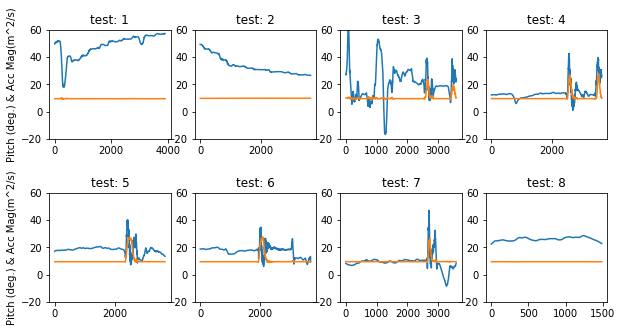

In [72]:
fig, axs = plt.subplots(2,4)
fig.subplots_adjust(hspace = .5, wspace=.2)


axs = axs.ravel()
i = 1
for start,stop in zip(sub1_start,sub1_stop):
    
    axs[i-1].plot(sig_pitch_weig_filt[int(start):int(stop)])
    axs[i-1].plot(sig_totMag_weig_filt[int(start):int(stop)])
    axs[i-1].set_title('test: '+str(i))
    axs[i-1].set_ylim(-20,60)

    i =  i+1
axs[0].set_ylabel('Pitch (deg.) & Acc Mag(m^2/s)')
axs[4].set_ylabel('Pitch (deg.) & Acc Mag(m^2/s)')
plt.show()



In [106]:
cv_test_track = []
sigDevEn_test_track = []

cv_test_track_acc = []
sigDevEn_test_acc_track = []
for start,stop in zip(sub1_start,sub1_stop):
    # for each test 
    # look at coefficient of variation - lower is better
    # look at signal energy - lower is better
    test_data = sig_pitch_weig_filt[int(start):int(stop)]
    test_data_acc = sig_totMag_weig_filt[int(start):int(stop)]

    cv_test_data = np.std(test_data)/np.mean(test_data)
    sigDevEn_test_data = np.sum((test_data-np.mean(test_data)) ** 2) / len(test_data)
    
    cv_test_track.append(cv_test_data)
    sigDevEn_test_track.append(sigDevEn_test_data)
    
    cv_test_data_acc = np.std(test_data_acc)/np.mean(test_data_acc)
    sigDevEn_test_data_acc = np.sum((test_data_acc-np.mean(test_data_acc)) ** 2) / len(test_data_acc)
    
    cv_test_track_acc.append(cv_test_data_acc)
    sigDevEn_test_acc_track.append(sigDevEn_test_data_acc)


subj_1_data = np.vstack((sigDevEn_test_track,cv_test_track,cv_test_track_acc,sigDevEn_test_acc_track)).T
subj_1_test_results = pd.DataFrame(subj_1_data, columns = ['sigDevEn_test_pitch','cv_test_pitch','sigDevEn_test_acc','cv_test_acc'])
subj_1_meta_data = [0]*8
subj_1_test_results['Metadata Results'] = subj_1_meta_data

print(subj_1_test_results)



   sigDevEn_test_pitch  cv_test_pitch  sigDevEn_test_acc  cv_test_acc  \
0            66.191577       0.168269           0.004970     0.002220   
1            38.415990       0.185369           0.003683     0.001306   
2           140.628968       0.562791           0.207167     4.475410   
3            28.825179       0.390510           0.295486     9.462173   
4            13.749725       0.200303           0.335522    12.378492   
5            12.243950       0.201362           0.307244    10.045069   
6            32.421337       0.610122           0.203296     4.092378   
7             1.521054       0.047153           0.000978     0.000086   

   Metadata Results  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
5                 0  
6                 0  
7                 0  


#### F.2) Balance metrics for subject 2
The balance metrics for test 8 on subject 2 look a bit strange, considering I see peaks in the data. I think I may have inadverently cuttoff the problem in subject 8. 

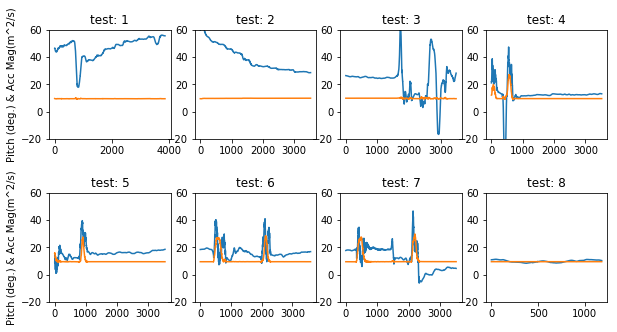

In [107]:
fig, axs = plt.subplots(2,4)
fig.subplots_adjust(hspace = .5, wspace=.2)

axs = axs.ravel()
i = 1
for start,stop in zip(sub2_start,sub2_stop):
    axs[i-1].plot(sig_pitch_weig_filt[int(start):int(stop)])
    axs[i-1].plot(sig_totMag_weig_filt[int(start):int(stop)])
    axs[i-1].set_title('test: '+str(i))
    axs[i-1].set_ylim(-20,60)
    i =  i+1
    
axs[0].set_ylabel('Pitch (deg.) & Acc Mag(m^2/s)')
axs[4].set_ylabel('Pitch (deg.) & Acc Mag(m^2/s)')
plt.show()

In [108]:
cv_test_track = []
sigDevEn_test_track = []

cv_test_track_acc = []
sigDevEn_test_acc_track = []
for start,stop in zip(sub2_start,sub2_stop):
    # for each test 
    # look at coefficient of variation - lower is better
    # look at signal energy - lower is better
    test_data = sig_pitch_weig_filt[int(start):int(stop)]
    test_data_acc = sig_totMag_weig_filt[int(start):int(stop)]

    cv_test_data = np.std(test_data)/np.mean(test_data)
    sigDevEn_test_data = np.sum((test_data-np.mean(test_data)) ** 2) / len(test_data)
    
    cv_test_track.append(cv_test_data)
    sigDevEn_test_track.append(sigDevEn_test_data)
    
    cv_test_data_acc = np.std(test_data_acc)/np.mean(test_data_acc)
    sigDevEn_test_data_acc = np.sum((test_data_acc-np.mean(test_data_acc)) ** 2) / len(test_data_acc)
    
    cv_test_track_acc.append(cv_test_data_acc)
    sigDevEn_test_acc_track.append(sigDevEn_test_data_acc)


subj_2_data = np.vstack((sigDevEn_test_track,cv_test_track,cv_test_track_acc,sigDevEn_test_acc_track)).T
subj_2_test_results = pd.DataFrame(subj_2_data, columns = ['sigDevEn_test_pitch','cv_test_pitch','sigDevEn_test_acc','cv_test_acc'])
subj_2_meta_data = [0,0,0,0,0,0,0,1]
subj_2_test_results['Metadata Results'] = subj_2_meta_data

print(subj_2_test_results)



   sigDevEn_test_pitch  cv_test_pitch  sigDevEn_test_acc  cv_test_acc  \
0            56.046570       0.159037           0.005097     0.002335   
1           106.211179       0.262905           0.006839     0.004472   
2           132.122769       0.508827           0.023660     0.053507   
3            93.940698       0.763876           0.270021     7.795176   
4            16.626918       0.252254           0.224389     5.051066   
5            25.701689       0.295880           0.388956    18.454961   
6            76.872469       0.717109           0.390439    18.569592   
7             0.757067       0.088035           0.001352     0.000167   

   Metadata Results  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
5                 0  
6                 0  
7                 1  


#### Moving window function 
The technique I settled on to apply my functions is a standard moving window method. The advantage that this method has is that it can also be used to support ML-based classification schemes, if need be. It's a modification of a time-series prediction loop I employ for a ML-based stock/FX-prediction tool. 

#### F.3) Balance metrics for subject 3

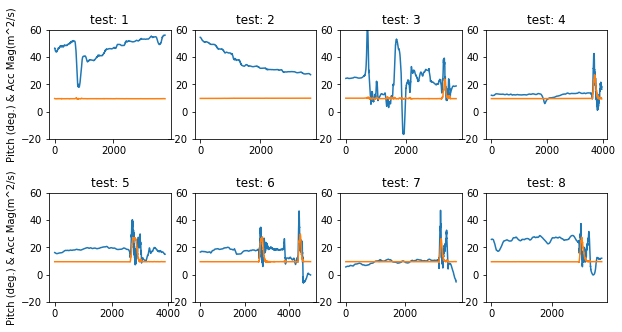

In [109]:
fig, axs = plt.subplots(2,4)
fig.subplots_adjust(hspace = .5, wspace=.2)

axs = axs.ravel()
i = 1
for start,stop in zip(sub3_start,sub3_stop):
    axs[i-1].plot(sig_pitch_weig_filt[int(start):int(stop)])
    axs[i-1].plot(sig_totMag_weig_filt[int(start):int(stop)])
    axs[i-1].set_title('test: '+str(i))
    axs[i-1].set_ylim(-20,60)

    i =  i+1
axs[0].set_ylabel('Pitch (deg.) & Acc Mag(m^2/s)')
axs[4].set_ylabel('Pitch (deg.) & Acc Mag(m^2/s)')
plt.show()

In [111]:
cv_test_track = []
sigDevEn_test_track = []

cv_test_track_acc = []
sigDevEn_test_acc_track = []
for start,stop in zip(sub3_start,sub3_stop):
    # for each test 
    # look at coefficient of variation - lower is better
    # look at signal energy - lower is better
    test_data = sig_pitch_weig_filt[int(start):int(stop)]
    test_data_acc = sig_totMag_weig_filt[int(start):int(stop)]

    cv_test_data = np.std(test_data)/np.mean(test_data)
    sigDevEn_test_data = np.sum((test_data-np.mean(test_data)) ** 2) / len(test_data)
    
    cv_test_track.append(cv_test_data)
    sigDevEn_test_track.append(sigDevEn_test_data)
    
    cv_test_data_acc = np.std(test_data_acc)/np.mean(test_data_acc)
    sigDevEn_test_data_acc = np.sum((test_data_acc-np.mean(test_data_acc)) ** 2) / len(test_data_acc)
    
    cv_test_track_acc.append(cv_test_data_acc)
    sigDevEn_test_acc_track.append(sigDevEn_test_data_acc)


subj_3_data = np.vstack((sigDevEn_test_track,cv_test_track,cv_test_track_acc,sigDevEn_test_acc_track)).T
subj_3_test_results = pd.DataFrame(subj_3_data, columns = ['sigDevEn_test_pitch','cv_test_pitch','sigDevEn_test_acc','cv_test_acc'])
subj_3_meta_data = [0,0,0,0,0,1,0,0]
subj_3_test_results['Metadata Results'] = subj_3_meta_data

print(subj_3_test_results)



   sigDevEn_test_pitch  cv_test_pitch  sigDevEn_test_acc  cv_test_acc  \
0            55.435815       0.158909           0.005150     0.002385   
1            63.025578       0.218771           0.004985     0.002384   
2           134.165680       0.529301           0.171631     2.949788   
3            13.230013       0.284502           0.218766     4.768271   
4            13.033283       0.196225           0.327677    11.675227   
5            39.438745       0.385995           0.348867    13.645796   
6            22.847076       0.488335           0.200174     3.954592   
7            45.571611       0.293305           0.245358     6.088434   

   Metadata Results  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
5                 1  
6                 0  
7                 0  


### G) Ranking performance
There are lots of ways to rank performance. I've calculated some interesting statistics from the pitch and acceleration signals. It's hard to do this in a fair way. Because I'm nearly out of time, it might be best to just assume that a 'pass' is '0' and a 'fail' is a '1'. Then use the rank function and do a bunch of rank and sums to skew the difficulty of a test to favor the metadata results (i.e., make sure the failed tests are ranked low). The lower the ranking the better.

In [113]:
# calculate the rankings for each column
subj_1_ranked = subj_1_test_results.rank()

# add a ranked column as an additional column 
# lowest score is best. 
subj_1_ranked['sum rank'] = subj_1_ranked.sum(axis=1).rank()
# print(subj_1_ranked)

subj_2_ranked = subj_2_test_results.rank()
subj_2_ranked['sum rank'] = subj_2_ranked.sum(axis=1).rank()
# print(subj_2_ranked)

subj_3_ranked = subj_3_test_results.rank()
subj_3_ranked['sum rank'] = subj_3_ranked.sum(axis=1).rank()
# print(subj_3_ranked)

# then create a new matrix with just the sum ranks for each
total_ranking = np.vstack((subj_1_ranked['sum rank'],subj_2_ranked['sum rank'],subj_3_ranked['sum rank'])).T

total_ranking_df = pd.DataFrame(total_ranking, columns=['subj_1_sum_rank','subj_2_sum_rank','subj_3_sum_rank'])

total_ranking_df['final_ranking'] = total_ranking_df.sum(axis=1).rank()
print(total_ranking_df)


   subj_1_sum_rank  subj_2_sum_rank  subj_3_sum_rank  final_ranking
0              3.0              2.0              1.0            1.0
1              2.0              4.0              2.0            2.0
2              8.0              5.5              6.5            8.0
3              6.0              7.0              3.0            5.0
4              7.0              3.0              4.0            4.0
5              4.5              5.5              8.0            7.0
6              4.5              8.0              5.0            6.0
7              1.0              1.0              6.5            3.0
